<a href="https://colab.research.google.com/github/rfprates/estudo_preco_glp/blob/main/Case_estudo_preco_GLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Case de Estudo do preço do gás GLP entre janeiro de 2020 a junho de 2023**

## Introdução

Em linhas gerais, o GLP, ou Gás Liquefeito de Petróleo, é um tipo de gás combustível composto principalmente por propano e butano. Ele é um subproduto do processo de refino de petróleo e também pode ser obtido durante a extração de gás natural.

A cadeia de produção do GLP se inicia lá nas refinarias de petróleo. Depois de diversos tratamentos e procedimentos industriais, este gás é enviado as distribuidoras, que os repassa para os revendedores de gás. Estes então são os que entregam o gás ao consumidor final, seja ele residencial, comercial ou uma indústria.

Desta forma, imbutido no preço final que o consumidor paga no gás, existem diversos fatores que o influênciam, como o custo e lucro dos distribuidores e revendedores, o preço do gás nas refinarias, além dos tributos estaduais e federais.

## Objetivo do projeto

Realizar um estudo sobre as diversas influências sobre o preço do GLP no Brasil e de que forma este variou ao longo dos últimos 3 anos, de janeiro de 2020 até junho de 2023.

## Bibliotecas utilizadas

In [41]:
# libs
import os
import pandas as pd
import numpy as np
import missingno as msno

# visualização dos dados
import seaborn as sns
import matplotlib.pyplot as plt

# tratamento de datas
import datetime

# SQL
import sqlite3

## Importando dataset de teste

Importando um dataset de teste,

In [6]:
teste = pd.read_csv('glp-2020-01.csv', sep = ';')
teste.head()

,Regiao - Sigla,Estado - Sigla,Municipio,Revenda,CNPJ da Revenda,Nome da Rua,Numero Rua,Complemento,Bairro,Cep,Produto,Data da Coleta,Valor de Venda,Valor de Compra,Unidade de Medida,Bandeira
0,SE,MG,SAO SEBASTIAO DO PARAISO,REDE DE POSTOS ZERO IV LTDA.,00.883.226/0001-88,RODOVIA BR 491 KM 03,3101,NaN,ITAMARATI,37950-000,GLP,02/01/2020,65,NaN,R$ / 13 kg,COPAGAZ
1,S,RS,SANTA MARIA,SANTA LUCIA COMERCIO E PAVIMENTACOES LTDA,87.305.868/0001-88,RODOVIA RS 509,1200,KM 03,JOÃO GOULART,97095-000,GLP,03/01/2020,80,NaN,R$ / 13 kg,ULTRAGAZ
2,N,AC,CRUZEIRO DO SUL,CARDINAL E OLIVEIRA LTDA,03.608.766/0006-56,AVENIDA 25 DE AGOSTO,1350,NaN,25 DE AGOSTO,69980-000,GLP,02/01/2020,78,"68,72",R$ / 13 kg,AMAZONGÁS
3,N,AC,CRUZEIRO DO SUL,CARDINAL E OLIVEIRA LTDA,03.608.766/0004-94,AVENIDA LAURO MULLER,943,NaN,JOÃO ALVES,69980-000,GLP,02/01/2020,78,"68,72",R$ / 13 kg,AMAZONGÁS
4,N,AC,RIO BRANCO,AUTO POSTO AMAPA - EIRELI,00.529.581/0001-53,VIA CHICO MENDES,3570,NaN,AREAL,69906-119,GLP,03/01/2020,82,"70,02",R$ / 13 kg,AMAZONGÁS


Verificando a quantidade de linhas e colunas do dataset,

In [7]:
teste.shape

(114241, 16)

Verificando a quantidade de dados nulos por coluna do dataset,

In [8]:
teste.isnull().sum()

Regiao - Sigla           0
Estado - Sigla           0
Municipio                0
Revenda                  0
CNPJ da Revenda          0
Nome da Rua              0
Numero Rua              17
Complemento          87070
Bairro                   0
Cep                      0
Produto                  0
Data da Coleta           0
Valor de Venda           0
Valor de Compra      84916
Unidade de Medida        0
Bandeira                 0
dtype: int64

Calculando agora a quantidade total de dados nulos,

In [9]:
teste.isnull().sum().sum()

172003

Verificando o tipo de dado presente em cada coluna,

In [10]:
teste.dtypes

Regiao - Sigla       object
Estado - Sigla       object
Municipio            object
Revenda              object
CNPJ da Revenda      object
Nome da Rua          object
Numero Rua           object
Complemento          object
Bairro               object
Cep                  object
Produto              object
Data da Coleta       object
Valor de Venda       object
Valor de Compra      object
Unidade de Medida    object
Bandeira             object
dtype: object

Uma forma de averiguar se os dados presentes no dataset são confiáveis, seria expor os dados das colunas de Região e Estado, pois são resultados que já sabe-se quais podem ser de antemão.

In [11]:
teste['Regiao - Sigla'].unique()

array(['SE', 'S', 'N', 'NE', 'CO'], dtype=object)

In [12]:
teste['Estado - Sigla'].unique()

array(['MG', 'RS', 'AC', 'AL', 'AM', 'BA', 'DF', 'ES', 'GO', 'MA', 'MS',
       'MT', 'PA', 'PB', 'PI', 'PR', 'RN', 'RO', 'SP', 'AP', 'CE', 'TO',
       'RJ', 'SC', 'SE', 'PE', 'RR'], dtype=object)

## Definindo uma função de verificação para todos os datasets

Feitas estas verificações iniciais, analisando que ainda tem-se 6 datasets, é difícil garantir que todos eles apresentam as informações da mesma forma, podem ter dados nulos em colunas diferentes, o prenchimento de algumas delas pode estar incorreto, podem ter colunas faltantes, etc. Portanto, se torna necessário uma conferência inicial em todos os datasets antes de enviar para o banco de dados em SQL.

Desta forma, estabeleceu-se abaixo algumas métricas estatísticas para serem averiguadas em cada um dos datasets, salvando a hora e também o nome do arquivo, antes de agrupar e enviá-los ao banco.

In [18]:
# testando o Data Frame a ser criado para todos os datasets

linhas = teste.shape[0]  # salva o número de linhas do dataset
colunas = teste.shape[1] # salva o número de colunas do dataset

distribuicao_nulos = teste.isnull().sum()                         # salva a quantidade de dados nulos por coluna
total_nulos = distribuicao_nulos.sum()                            # salva o total de dados nulos do dataset
colunas_nulas = distribuicao_nulos[distribuicao_nulos>0].index    # salva as colunas que apresentam dados nulos

tipos_campos = teste.dtypes  # salva o tipo de dado presente em cada coluna do dataset

regioes = teste['Regiao - Sigla'].unique()   # salva os dados de regiao do dataset
estados = teste['Estado - Sigla'].unique()   # salva os dados de estado do dataset


# definindo-se o dicionário que irá compor o DataFrame com as informações de cada um dos datasets
dicionario = {
      'total_registros': linhas,
      'total_colunas': colunas,
      'total_linhas_nulas': total_nulos,
      'colunas_nulas': [colunas_nulas],
      'tipo_campos': [tipos_campos],
      'dados_regiao': [regioes],
      'dados_estado': [estados]
}

pd.DataFrame(data = dicionario, index = [0])

,total_registros,total_colunas,total_linhas_nulas,colunas_nulas,tipo_campos,dados_regiao,dados_estado
0,114241,16,172003,"Index(['Numero Rua', 'Complemento', 'Valor de ...",Regiao - Sigla object Estado - Sigla ...,"[SE, S, N, NE, CO]","[MG, RS, AC, AL, AM, BA, DF, ES, GO, MA, MS, M..."


In [19]:
# Função que irá verificar as estatísticas de todos os datasets lidos, gerando o Log com todas as infos de cada um deles

def validar_arquivo(base_dados, nome_arquivo):

  linhas = base_dados.shape[0]
  colunas = base_dados.shape[1]

  distribuicao_nulos = base_dados.isnull().sum()
  total_nulos = distribuicao_nulos.sum()
  colunas_nulas = distribuicao_nulos[distribuicao_nulos>0].index

  tipos_campos = base_dados.dtypes

  regioes = base_dados['Regiao - Sigla'].unique()
  estados = base_dados['Estado - Sigla'].unique()

  nome_arquivo = str(nome_arquivo)        # salva o nome do arquivo do dataset
  data = datetime.datetime.now().date()   # salva a data em que o dataset foi testado
  hora = datetime.datetime.now().time()   # salva a hora em que o dataset foi testado

  # definindo-se o dicionário que irá compor o log de cada um dos datasets
  dicionario = {
      'total_registros': linhas,
      'total_colunas': colunas,
      'total_linhas_nulas': total_nulos,
      'colunas_nulas': [colunas_nulas],
      'tipo_campos': [tipos_campos],
      'dados_regiao': [regioes],
      'dados_estado': [estados],
      'nome_arquivo': nome_arquivo,
      'data': data,
      'hora': hora
  }

  log = pd.DataFrame(data = dicionario, index = [0])

  return log

## Tratamento e ingestão dos datasets no banco de dados

Definida a função para salvar o log de cada dataset lido, agora pode-se seguir para a etapa de ingestao no banco. Nesta etapa vamos:
* ler cada dataset e empilhar em um único arquivo;
* criar um banco de dados e uma tabela usando SQL;
* levar os dados para o banco de dados.

### Lendo cada dataset e empilhando em um único arquivo

In [20]:
# Estrutura para consolidar os arquivos baixados

# Local para buscar os datasets baixados
local = '/content/'

# Variáveis de apoio
base_consolidada = pd.DataFrame()   # Data Frame vazio criado que posteriormente irá receber todos os datasets empilhados
base_log = pd.DataFrame()           # Data Frame vazio criado que posteriormente irá receber todos os logs dos datasets carregados que irão servir de base para o dataset empilhado

# Loop para percorrer o diretório onde estão salvos os arquivos dos datasets baixados
for diretorio, subpastas, arquivos in os.walk(local):
  # acessando os todos os arquivos presentes dentro do diretorio correspondente ao local repassado
  for arquivo in arquivos:
    if '.csv' in arquivo and 'glp' in arquivo:
      # empilhando todos os datasets no dataframe criado anteriormente
      base = pd.read_csv(local+f'{arquivo}', sep = ';')
      base_consolidada = pd.concat([base_consolidada, base])

      # salvando os logs dos datasets
      base_log = pd.concat([base_log, validar_arquivo(base, arquivo)])


Acessando-se agora a base_log, já com os logs de todos os datasets lidos e empilhados,

In [16]:
base_log

,total_registros,total_colunas,total_linhas_nulas,colunas_nulas,tipo_campos,dados_regiao,dados_estado,nome_arquivo,data,hora
0,67371,16,118718,"Index(['Numero Rua', 'Complemento', 'Bairro', ...",Regiao - Sigla object Estado - Sigla ...,"[NE, CO, SE, S, N]","[PI, GO, MG, SP, SC, AM, PA, PB, PE, PR, RO, R...",glp-2022-02.csv,2023-10-20,18:17:08.621492
0,60280,16,106237,"Index(['Complemento', 'Valor de Compra'], dtyp...",Regiao - Sigla object Estado - Sigla ...,"[SE, S, N, NE, CO]","[SP, RJ, RS, AC, CE, DF, MA, MG, MS, PA, PB, P...",glp-2021-01.csv,2023-10-20,18:17:09.030306
0,114241,16,172003,"Index(['Numero Rua', 'Complemento', 'Valor de ...",Regiao - Sigla object Estado - Sigla ...,"[SE, S, N, NE, CO]","[MG, RS, AC, AL, AM, BA, DF, ES, GO, MA, MS, M...",glp-2020-01.csv,2023-10-20,18:17:09.763786
0,100133,16,176302,"Index(['Numero Rua', 'Complemento', 'Bairro', ...",Regiao - Sigla object Estado - Sigla ...,"[SE, N, NE, S, CO]","[SP, AC, CE, MA, PA, RS, PR, GO, MG, PB, TO, B...",glp-2022-01.csv,2023-10-20,18:17:10.857432
0,89372,16,157691,"Index(['Numero Rua', 'Complemento', 'Bairro', ...",Regiao - Sigla object Estado - Sigla ...,"[NE, S, SE, CO, N]","[CE, SC, MA, SP, PB, RS, PR, PE, RJ, GO, MT, R...",glp-2021-02.csv,2023-10-20,18:17:11.948617
0,105341,16,184286,"Index(['Complemento', 'Bairro', 'Valor de Comp...",Regiao - Sigla object Estado - Sigla ...,"[CO, S, SE, NE, N]","[MS, RS, MG, CE, BA, DF, ES, MA, PA, PB, PE, P...",glp-2023-01.csv,2023-10-20,18:17:12.948837
0,45412,16,73510,"Index(['Numero Rua', 'Complemento', 'Valor de ...",Regiao - Sigla object Estado - Sigla ...,"[S, N, NE, CO, SE]","[RS, AM, BA, DF, GO, MA, MS, PB, PR, SC, SP, C...",glp-2020-02.csv,2023-10-20,18:17:13.312074


Acessando-se agora o data frame criado com todos os datasets empilhados,

In [17]:
base_consolidada

,Regiao - Sigla,Estado - Sigla,Municipio,Revenda,CNPJ da Revenda,Nome da Rua,Numero Rua,Complemento,Bairro,Cep,Produto,Data da Coleta,Valor de Venda,Valor de Compra,Unidade de Medida,Bandeira
0,NE,PI,TERESINA,J A SILVA MERCADINHO,23.621.717/0002-37,RUA MINISTRO PEDRO BORGES,1560,NaN,TABOLETA,64019-650,GLP,01/07/2022,115,NaN,R$ / 13 kg,NACIONAL GÁS BUTANO
1,CO,GO,GOIANIA,VB FORTE GAS LTDA - ME,37.664.869/0001-40,AVENIDA BARAO DO RIO BRANCO,914,"QD. 66, LT. 07",JARDIM VILA BOA,74360-230,GLP,01/07/2022,125,NaN,R$ / 13 kg,SUPERGASBRAS ENERGIA
2,NE,PI,TERESINA,T DE L N FERREIRA LTDA,05.584.976/0002-53,R IVAN TITO DE OLIVEIRA,2086,SUL,LOURIVAL PARENTE,64023-500,GLP,01/07/2022,115,NaN,R$ / 13 kg,LIQUIGÁS
3,SE,MG,DIVINOPOLIS,VALDINEI SOARES DA SILVA,04.580.941/0001-00,RUA IBIRITÉ,66,NaN,BOM PASTOR,35500-191,GLP,01/07/2022,110,NaN,R$ / 13 kg,SUPERGASBRAS ENERGIA
4,SE,MG,DIVINOPOLIS,DF COMERCIO DE GAS LTDA,04.538.114/0001-40,ALAMEDA RIO PERDIDO,206,NaN,TIETE,35501-179,GLP,01/07/2022,105,NaN,R$ / 13 kg,BRANCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45407,NE,PE,RECIFE,R A DE LIMA & CIA LTDA,36.989.791/0001-71,AVENIDA LIBERDADE,1546,NaN,SANCHO,50920-310,GLP,27/12/2020,70,NaN,R$ / 13 kg,COPAGAZ
45408,SE,MG,MONTES CLAROS,W DIAS GAS EIRELI,34.473.925/0001-71,RUA MANOEL BANDEIRA,815,NaN,PLANALTO,39404-035,GLP,28/12/2020,84,NaN,R$ / 13 kg,LIQUIGÁS
45409,NE,CE,FORTALEZA,E J COMERCIO VAREJISTA DE GLP LTDA,37.106.195/0001-69,RUA PROFESSOR PAULO LOPES,1041,NaN,DOM LUSTOSA,60526-045,GLP,29/12/2020,83,NaN,R$ / 13 kg,NACIONAL GÁS BUTANO
45410,SE,SP,OSASCO,PRA JA GAS E AGUA COMERCIO VAREJISTA LTDA,37.302.782/0001-23,ESTRADA DAS MARGARIDAS,200,NaN,SANTA MARIA,06150-490,GLP,29/12/2020,"77,99",NaN,R$ / 13 kg,BRANCA


É possível observar que agora o dataset empilhado tem 582150 linhas e 16 colunas. Avalindo-se o nome das colunas, podem ser feitos alguns tratamentos, a fim de padronização as normas de programação, como retirar espaços e colocar todos em letras minúsculas. Isto é feito conforme demonstrado abaixo,

In [21]:
base_consolidada.columns

Index(['Regiao - Sigla', 'Estado - Sigla', 'Municipio', 'Revenda',
       'CNPJ da Revenda', 'Nome da Rua', 'Numero Rua', 'Complemento', 'Bairro',
       'Cep', 'Produto', 'Data da Coleta', 'Valor de Venda', 'Valor de Compra',
       'Unidade de Medida', 'Bandeira'],
      dtype='object')

In [22]:
base_consolidada.columns = [column.replace(' - ','_').replace(' ','_').lower() for column in base_consolidada.columns]
base_consolidada.columns

Index(['regiao_sigla', 'estado_sigla', 'municipio', 'revenda',
       'cnpj_da_revenda', 'nome_da_rua', 'numero_rua', 'complemento', 'bairro',
       'cep', 'produto', 'data_da_coleta', 'valor_de_venda', 'valor_de_compra',
       'unidade_de_medida', 'bandeira'],
      dtype='object')

Conforme avaliado no início do projeto, no dataset de teste, a coluna "data_da_coleta" tem dados de datas contudo estão do tipo object. É necessário convertê-la para o tipo datetime, conforme segue,

In [23]:
base_consolidada.dtypes

regiao_sigla         object
estado_sigla         object
municipio            object
revenda              object
cnpj_da_revenda      object
nome_da_rua          object
numero_rua           object
complemento          object
bairro               object
cep                  object
produto              object
data_da_coleta       object
valor_de_venda       object
valor_de_compra      object
unidade_de_medida    object
bandeira             object
dtype: object

In [24]:
base_consolidada['data_da_coleta'] = pd.to_datetime(base_consolidada['data_da_coleta'], format = '%d/%m/%Y', errors = 'coerce')

In [25]:
base_consolidada.dtypes

regiao_sigla                 object
estado_sigla                 object
municipio                    object
revenda                      object
cnpj_da_revenda              object
nome_da_rua                  object
numero_rua                   object
complemento                  object
bairro                       object
cep                          object
produto                      object
data_da_coleta       datetime64[ns]
valor_de_venda               object
valor_de_compra              object
unidade_de_medida            object
bandeira                     object
dtype: object

Com isso, agora é possível extrair o ano e o mês em que foram coletados os valores,

In [26]:
base_consolidada['mes_coleta'] = base_consolidada['data_da_coleta'].dt.month
base_consolidada['ano_coleta'] = base_consolidada['data_da_coleta'].dt.year

Observando por fim a cara do dataset empilhado,

In [27]:
base_consolidada.head()

,regiao_sigla,estado_sigla,municipio,revenda,cnpj_da_revenda,nome_da_rua,numero_rua,complemento,bairro,cep,produto,data_da_coleta,valor_de_venda,valor_de_compra,unidade_de_medida,bandeira,mes_coleta,ano_coleta
0,NE,PI,TERESINA,J A SILVA MERCADINHO,23.621.717/0002-37,RUA MINISTRO PEDRO BORGES,1560,NaN,TABOLETA,64019-650,GLP,2022-07-01,115,NaN,R$ / 13 kg,NACIONAL GÁS BUTANO,7,2022
1,CO,GO,GOIANIA,VB FORTE GAS LTDA - ME,37.664.869/0001-40,AVENIDA BARAO DO RIO BRANCO,914,"QD. 66, LT. 07",JARDIM VILA BOA,74360-230,GLP,2022-07-01,125,NaN,R$ / 13 kg,SUPERGASBRAS ENERGIA,7,2022
2,NE,PI,TERESINA,T DE L N FERREIRA LTDA,05.584.976/0002-53,R IVAN TITO DE OLIVEIRA,2086,SUL,LOURIVAL PARENTE,64023-500,GLP,2022-07-01,115,NaN,R$ / 13 kg,LIQUIGÁS,7,2022
3,SE,MG,DIVINOPOLIS,VALDINEI SOARES DA SILVA,04.580.941/0001-00,RUA IBIRITÉ,66,NaN,BOM PASTOR,35500-191,GLP,2022-07-01,110,NaN,R$ / 13 kg,SUPERGASBRAS ENERGIA,7,2022
4,SE,MG,DIVINOPOLIS,DF COMERCIO DE GAS LTDA,04.538.114/0001-40,ALAMEDA RIO PERDIDO,206,NaN,TIETE,35501-179,GLP,2022-07-01,105,NaN,R$ / 13 kg,BRANCA,7,2022


### Criando o banco de dados e tabela com SQL

Para criar o banco de dados e a tabela que irá receber o dataset empilhado, pode-se utilizar da biblioteca importada anteriormente "sqlite3".

Primeiro, criou-se um banco de dados sqlite, utilizando a função connect( ),

In [28]:
# Criar o banco de dados (ou conectar-se a ele caso já exista)
conexao = sqlite3.connect('db_glp.db')

Com o banco de dados criado, ali dentro é possível realizar as consultas em sql (query), drops, updates, criar tabelas e etc.

Feito isto, ainda é necessário criar um cursor, como se fosse um ponteiro, para que o python para apontar para o database quando for realizada alguma ação relacionado a ele.

In [29]:
# Criar cursor
cursor = conexao.cursor()

Agora, pode-se envia a consulta em SQL pelo cursor, solicitando a criação da tabela no db, e salvar as respectivas atualizações, conforme demonstrado abaixo.

In [30]:
# Consulta solicitando a criação da tabela tab_dados_glp -> código escrito em SQL
query_sql = '''
CREATE TABLE IF NOT EXISTS tab_dados_glp (
  regiao_sigla TEXT,
  estado_sigla TEXT,
  municipio TEXT,
  revenda TEXT,
  cnpj_da_revenda TEXT,
  nome_da_rua TEXT,
  numero_rua TEXT,
  complemento TEXT,
  bairro TEXT,
  cep TEXT,
  produto TEXT,
  data_da_coleta DATETIME,
  valor_de_venda INTEGER,
  valor_de_compra INTEGER,
  unidade_de_medida TEXT,
  bandeira TEXT,
  Ano_Coleto INTEGER,
  Mes_Coleto INTEGER
)
'''

# chamando o cursor para executar a consulta dentro do banco de dados criado
cursor.execute(query_sql)

# salvando as alterações no db
conexao.commit()
# fechando a conexão ao db
conexao.close()

Verificando a existência da tabela criada anteriormente no db,

In [31]:
# conectando ao banco de dados
conn = sqlite3.connect('db_glp.db')

# criando o cursor para que o python se comunique diremante ao db
cursor = conn.cursor()

# executando a consulta em SQL pelo cursor, onde irá buscar o nome de todos os arquivos do tipo tabela presentes dentro do banco de dados criado
cursor.execute("SELECT name FROM sqlite_master WHERE type = 'table'")

# recuperando os resultados da consulta acima
tabelas = cursor.fetchall()

# printando o nome das tabelas
for tabela in tabelas:
  print(tabela[0])

# fechando a conexao
conn.close()

tab_dados_glp


Portanto, conforme esperado, existe apenas a tabela 'tab_dados_glp' dentro do banco de dados.

### Inserindo os dados do dataset empilhado na tabela criada dentro do banco de dados

Com o banco de dados e a tabela criada dentro dele, agora é possível inserir os dados do dataset empilhado dentro da tabela.

In [34]:
# conectando ao banco de dados
conn = sqlite3.connect('db_glp.db')

# criando o cursor
cursor = conn.cursor

# inserindo os dados do dataset na tabela criada dentro do banco de dados
base_consolidada.to_sql(
    name = 'tab_dados_glp',   # argumento para passar o nome da tabela presente no database em que se deseja salvar os dados do Data Frame
    con = conn,               # argumento que recebe a conexão ao respectivo banco de dados criado
    if_exists = 'replace',    # argumento para explicar ao python que, se já existir dados dentro da tabela, é para substituí-los por estes novos
    index = False             # argumento para explicar ao python que não é para criar uma nova coluna na tabela do db com o index do Data Frame
)

# fechando a conexão
conn.close()

Para garantir que os dados do Data Frame empilhado foram salvos corretamente na tabela do database, criou-se uma consulta em SQL exibindo as primeiras 10 linhas da tabela 'tab_dados_glp'.

In [35]:
# conectando ao banco de dados
conn = sqlite3.connect('db_glp.db')

# consulta para exibir as 10 primeiras linhas de todas as colunas da tabela
query = '''
SELECT * FROM tab_dados_glp
LIMIT 10
'''

# chamando o argumento read_sql do Pandas para ler e executar a consulta em SQL
pd.read_sql(sql = query, con = conn)

,regiao_sigla,estado_sigla,municipio,revenda,cnpj_da_revenda,nome_da_rua,numero_rua,complemento,bairro,cep,produto,data_da_coleta,valor_de_venda,valor_de_compra,unidade_de_medida,bandeira,mes_coleta,ano_coleta
0,NE,PI,TERESINA,J A SILVA MERCADINHO,23.621.717/0002-37,RUA MINISTRO PEDRO BORGES,1560,None,TABOLETA,64019-650,GLP,2022-07-01 00:00:00,115,None,R$ / 13 kg,NACIONAL GÁS BUTANO,7,2022
1,CO,GO,GOIANIA,VB FORTE GAS LTDA - ME,37.664.869/0001-40,AVENIDA BARAO DO RIO BRANCO,914,"QD. 66, LT. 07",JARDIM VILA BOA,74360-230,GLP,2022-07-01 00:00:00,125,None,R$ / 13 kg,SUPERGASBRAS ENERGIA,7,2022
2,NE,PI,TERESINA,T DE L N FERREIRA LTDA,05.584.976/0002-53,R IVAN TITO DE OLIVEIRA,2086,SUL,LOURIVAL PARENTE,64023-500,GLP,2022-07-01 00:00:00,115,None,R$ / 13 kg,LIQUIGÁS,7,2022
3,SE,MG,DIVINOPOLIS,VALDINEI SOARES DA SILVA,04.580.941/0001-00,RUA IBIRITÉ,66,None,BOM PASTOR,35500-191,GLP,2022-07-01 00:00:00,110,None,R$ / 13 kg,SUPERGASBRAS ENERGIA,7,2022
4,SE,MG,DIVINOPOLIS,DF COMERCIO DE GAS LTDA,04.538.114/0001-40,ALAMEDA RIO PERDIDO,206,None,TIETE,35501-179,GLP,2022-07-01 00:00:00,105,None,R$ / 13 kg,BRANCA,7,2022
5,SE,SP,BARUERI,SÉRGIO MOISES DAVIDIAN GÁS ME.,08.776.470/0001-53,RUA IPANEMA,39,None,JARDIM MARIA HELENA,06445-100,GLP,2022-07-01 00:00:00,122,None,R$ / 13 kg,BRANCA,7,2022
6,NE,PI,TERESINA,JOSEVAN O. MAIA COMÉRCIO DE GÁS,10.940.786/0001-80,RUA PICOS,3084,SUL,PIÇARRA,64016-280,GLP,2022-07-01 00:00:00,120,None,R$ / 13 kg,BAHIANA,7,2022
7,CO,GO,GOIANIA,GLAUCIO ALVES FERREIRA,11.163.860/0001-62,RUA BOULEVARD AMENDOEIRAS,31,QD 67 LT 01,JARDIM ATLANTICO,74343-030,GLP,2022-07-01 00:00:00,125,None,R$ / 13 kg,SUPERGASBRAS ENERGIA,7,2022
8,SE,SP,BARUERI,ERIK PAULO SANTOS,05.736.195/0006-60,AVENIDA ITAQUI,301,None,JARDIM BELVAL,06420-210,GLP,2022-07-01 00:00:00,"109,99",None,R$ / 13 kg,BRANCA,7,2022
9,NE,PI,TERESINA,J DA CRUZ E SILVA,13.644.674/0001-70,RUA QUINZE DE NOVEMBRO,6179,QUADRA: 00G LOTE 04;,LOURIVAL PARENTE,64022-350,GLP,2022-07-01 00:00:00,120,None,R$ / 13 kg,NACIONAL GÁS BUTANO,7,2022


Logo, como demonstra o resultado acima, os dados do Data Frame dos datasets empilhados foram inseridos corretamente na tabela criada dentro do database em SQL.

## Análise Exploratória dos Dados

### Importando os dados em Pandas

Agora, vamos ler os dados presentes na tabela do banco de dados em SQL, e salvá-los em um Data Frame do Pandas, para serem feitos os respectivos tratamentos e análises,

In [36]:
conn = sqlite3.connect('db_glp.db')

base_dados = pd.read_sql(sql = 'SELECT * FROM tab_dados_glp', con = conn)

conn.close()

In [43]:
base_dados

,regiao_sigla,estado_sigla,municipio,revenda,cnpj_da_revenda,nome_da_rua,numero_rua,complemento,bairro,cep,produto,data_da_coleta,valor_de_venda,valor_de_compra,unidade_de_medida,bandeira,mes_coleta,ano_coleta
0,NE,PI,TERESINA,J A SILVA MERCADINHO,23.621.717/0002-37,RUA MINISTRO PEDRO BORGES,1560,None,TABOLETA,64019-650,GLP,2022-07-01 00:00:00,115,None,R$ / 13 kg,NACIONAL GÁS BUTANO,7,2022
1,CO,GO,GOIANIA,VB FORTE GAS LTDA - ME,37.664.869/0001-40,AVENIDA BARAO DO RIO BRANCO,914,"QD. 66, LT. 07",JARDIM VILA BOA,74360-230,GLP,2022-07-01 00:00:00,125,None,R$ / 13 kg,SUPERGASBRAS ENERGIA,7,2022
2,NE,PI,TERESINA,T DE L N FERREIRA LTDA,05.584.976/0002-53,R IVAN TITO DE OLIVEIRA,2086,SUL,LOURIVAL PARENTE,64023-500,GLP,2022-07-01 00:00:00,115,None,R$ / 13 kg,LIQUIGÁS,7,2022
3,SE,MG,DIVINOPOLIS,VALDINEI SOARES DA SILVA,04.580.941/0001-00,RUA IBIRITÉ,66,None,BOM PASTOR,35500-191,GLP,2022-07-01 00:00:00,110,None,R$ / 13 kg,SUPERGASBRAS ENERGIA,7,2022
4,SE,MG,DIVINOPOLIS,DF COMERCIO DE GAS LTDA,04.538.114/0001-40,ALAMEDA RIO PERDIDO,206,None,TIETE,35501-179,GLP,2022-07-01 00:00:00,105,None,R$ / 13 kg,BRANCA,7,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582145,NE,PE,RECIFE,R A DE LIMA & CIA LTDA,36.989.791/0001-71,AVENIDA LIBERDADE,1546,None,SANCHO,50920-310,GLP,2020-12-27 00:00:00,70,None,R$ / 13 kg,COPAGAZ,12,2020
582146,SE,MG,MONTES CLAROS,W DIAS GAS EIRELI,34.473.925/0001-71,RUA MANOEL BANDEIRA,815,None,PLANALTO,39404-035,GLP,2020-12-28 00:00:00,84,None,R$ / 13 kg,LIQUIGÁS,12,2020
582147,NE,CE,FORTALEZA,E J COMERCIO VAREJISTA DE GLP LTDA,37.106.195/0001-69,RUA PROFESSOR PAULO LOPES,1041,None,DOM LUSTOSA,60526-045,GLP,2020-12-29 00:00:00,83,None,R$ / 13 kg,NACIONAL GÁS BUTANO,12,2020
582148,SE,SP,OSASCO,PRA JA GAS E AGUA COMERCIO VAREJISTA LTDA,37.302.782/0001-23,ESTRADA DAS MARGARIDAS,200,None,SANTA MARIA,06150-490,GLP,2020-12-29 00:00:00,"77,99",None,R$ / 13 kg,BRANCA,12,2020


Avaliando as informações acima, tem-se todas as 18 colunas previstas, com 582150 linhas.

### Análise dos dados nulos presentes

Plotou-se abaixo um gráfico de mapa de calor para exibir os dados nulos presentes na base.

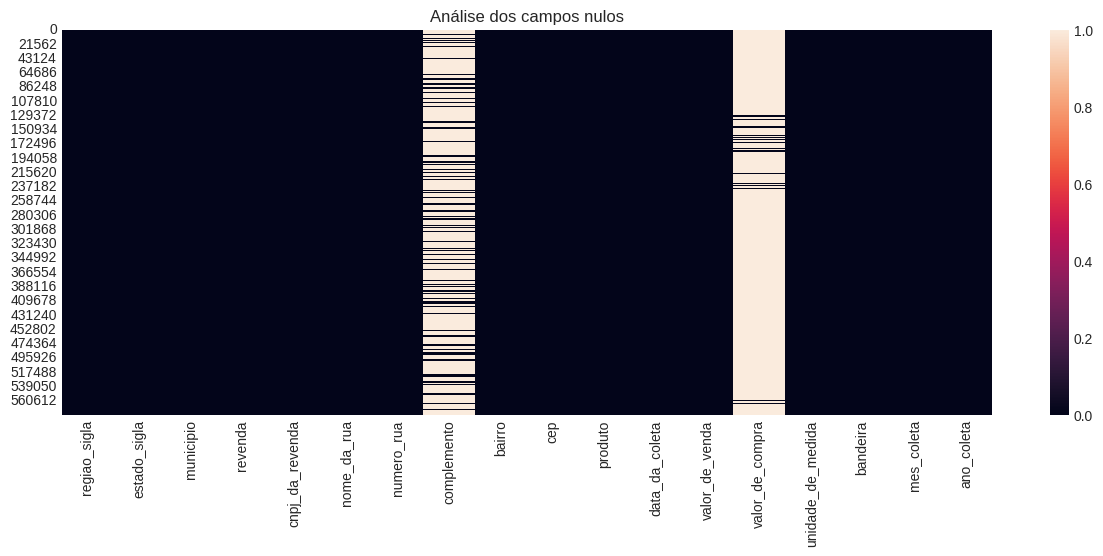

In [39]:
# campos nulos

plt.figure(figsize = (15,5))
plt.title('Análise dos campos nulos')
sns.heatmap(data = base_dados.isnull());

O gráfico acima indica que, todos as linhas que estão preenchidas como 1, indicam presença de dados nulos naquela coluna. Portanto, conforme previsto, as únicas colunas com dados nulos são "complemento" e "valor_de_compra". As demais não apresentam dados nulos.

Outra forma de verificar isto é utilizando o gráfico matrix( ) da biblioteca Missingno.

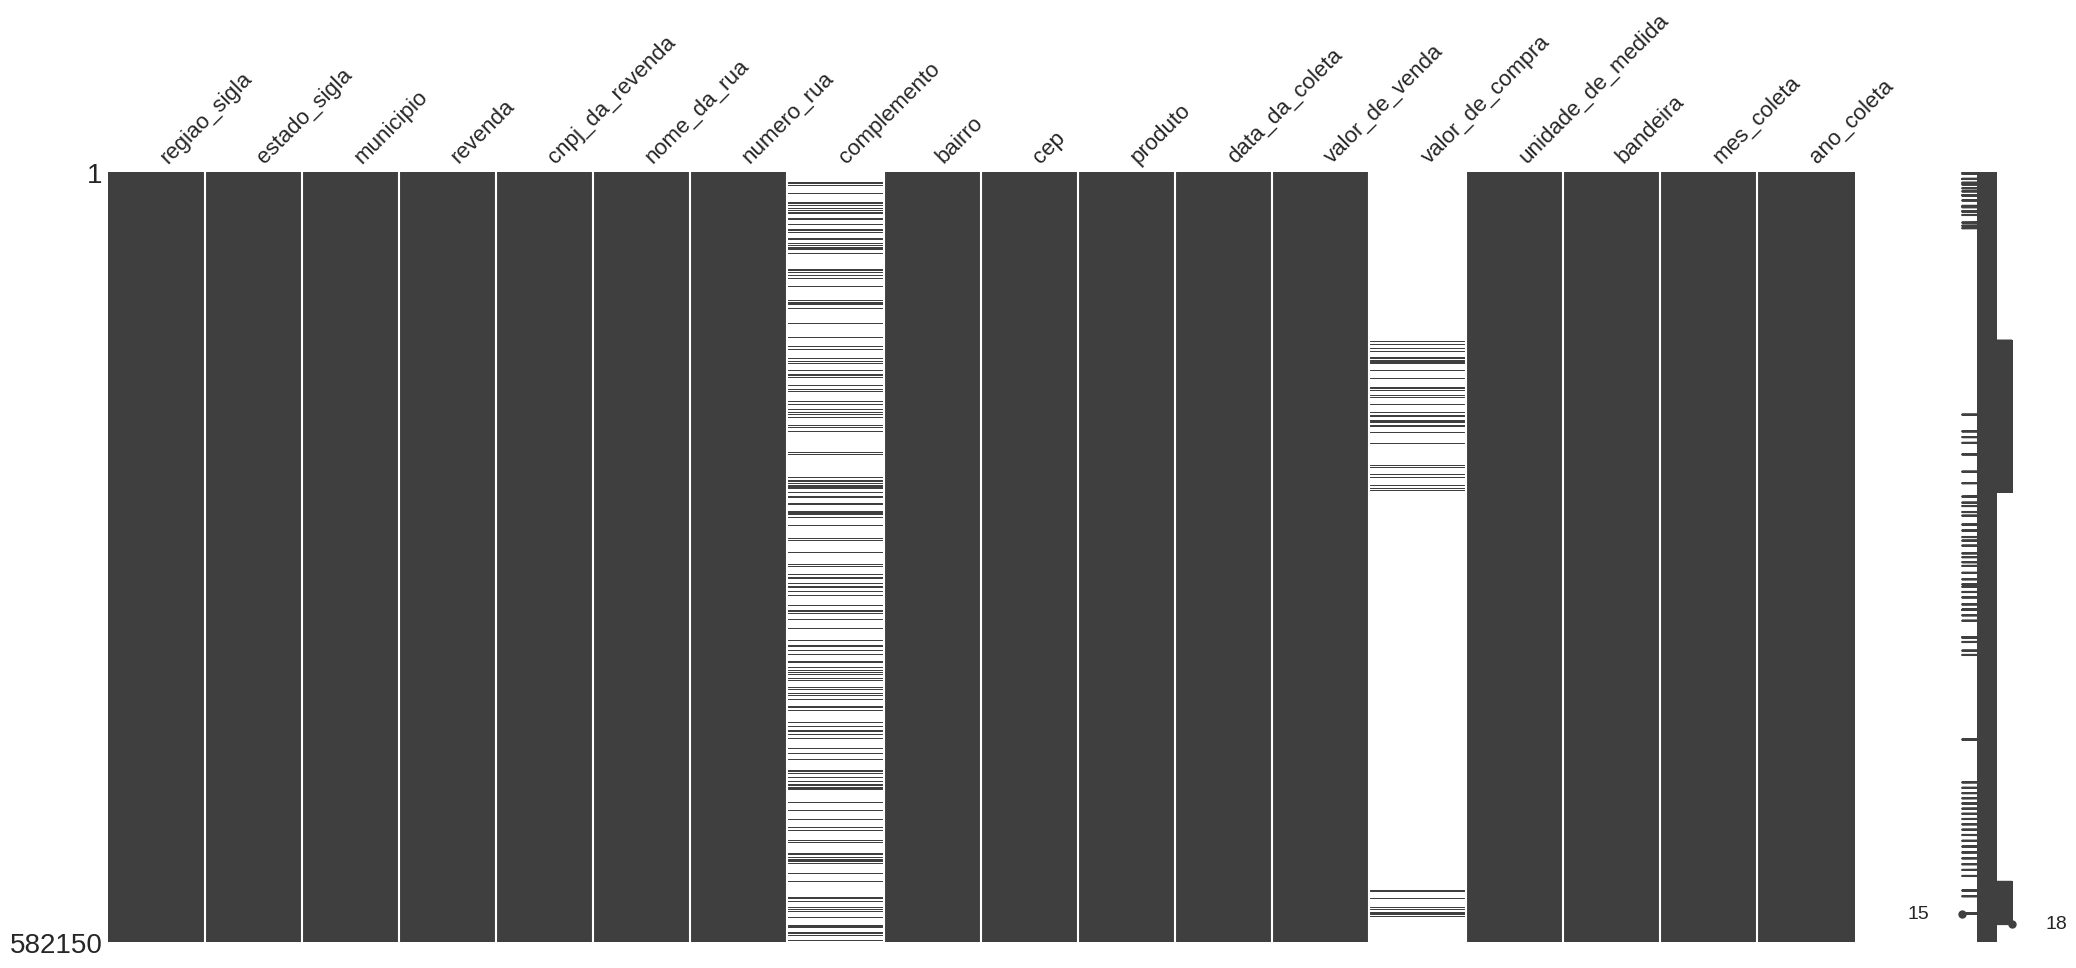

In [42]:
msno.matrix(base_dados);

### Análises estatísticas da coluna 'valor_de_venda'

Como o objetivo deste projeto é fazer análises a partir do valor de venda do gás GLP, primeiro é necessário verificar se a coluna 'valor_de_venda' está com o tipo de dados correto,

In [44]:
base_dados.dtypes

regiao_sigla         object
estado_sigla         object
municipio            object
revenda              object
cnpj_da_revenda      object
nome_da_rua          object
numero_rua           object
complemento          object
bairro               object
cep                  object
produto              object
data_da_coleta       object
valor_de_venda       object
valor_de_compra      object
unidade_de_medida    object
bandeira             object
mes_coleta            int64
ano_coleta            int64
dtype: object

Como observado acima a coluna 'valor_de_venda' está com dados do tipo 'object', logo é necessário convertê-los para numérico. Para realizar tal operação, foi necessário antes substituir todas as vírgulas presentes nos dados desta coluna por ponto, para que o Python conseguisse identificar e converter tal número para decimal.

In [45]:
base_dados['valor_de_venda'] = base_dados['valor_de_venda'].apply(lambda dado: dado.replace(',', '.'))
base_dados['valor_de_venda'] = base_dados['valor_de_venda'].astype('float')

In [46]:
base_dados['valor_de_venda'].dtypes

dtype('float64')

Com os dados da coluna devidamente convertidos, analisou-se as estatísticas descritivas desta coluna.

In [47]:
base_dados['valor_de_venda'].describe()

count    582150.000000
mean         94.902217
std          19.242097
min          49.900000
25%          78.000000
50%          98.000000
75%         110.000000
max         160.000000
Name: valor_de_venda, dtype: float64

Tem-se que a média do preço de venda do GLP entre janeiro 2020 e junho de 2023 é R$ 94,90. Mas será que este valor é confiável? Como estão as distribuições destes dados? Logo de cara é possível avaliar que o desvio padrão médio é 19, um valor relativamente ok. Contudo, como se pretende fazer análises mais profundas, o melhor a se fazer é avaliar o comportamento deste valor de venda ao longo de todo o período analisado.

Para isso, foi feito um agrupamento da base de dados a partir do ano e mês de coleta, exibindo a média do valor de venda, o desvio padrão e mediana para todos os meses de análise.

In [48]:
base_dados.groupby(
    by = ['ano_coleta', 'mes_coleta']
).agg(
    Quantidade = ('valor_de_venda', 'count'),
    Média = ('valor_de_venda', 'mean'),
    Mediana = ('valor_de_venda', 'median'),
    Desvio_Padrão = ('valor_de_venda', 'std')
).reset_index()

,ano_coleta,mes_coleta,Quantidade,Média,Mediana,Desvio_Padrão
0,2020,1,20793,70.626936,70.000,8.021403
1,2020,2,17477,70.789624,70.000,7.970337
2,2020,3,19492,70.843771,70.000,7.901932
3,2020,4,19240,70.855663,70.000,7.551256
4,2020,5,17427,70.471334,70.000,7.422980
5,2020,6,19812,70.581333,70.000,7.589573
6,2020,7,19378,70.805588,70.000,7.434778
7,2020,8,12463,71.045171,70.000,7.642308
8,2020,10,1392,74.971385,75.000,8.570577
9,2020,11,4801,75.240802,75.000,8.290593


Avaliando-se os resultados acima, percebe-se que a média e a mediana permanecem com valores muito próximos entre eles ao longo de todo o período analisado, com pouca oscilação no valor do desvio padrão.

Para melhor visualização destes resultados, plotou-se um histograma do valor de venda, com a distribuição e suas respectivas frequências. Além disso, no mesmo gráfico plotou-se retas de linhas traçejadas representando onde se encontra a média e a mediana destes valores, além do grau de assimetria destes dados.

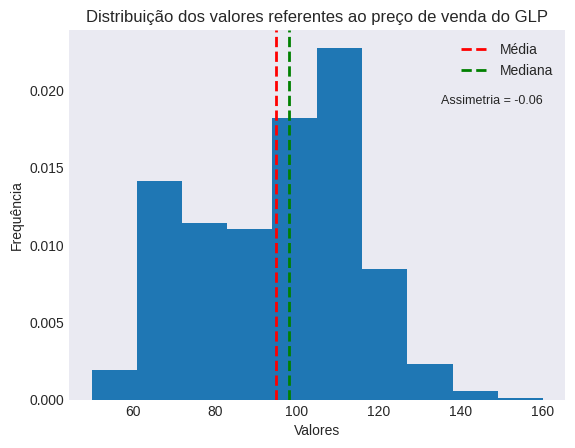

In [70]:
plt.hist(base_dados['valor_de_venda'], density = True)

# Adicionando uma reta traçejada para representar a média
media_preco = base_dados['valor_de_venda'].mean()
plt.axvline(media_preco, color='red', linestyle='dashed', linewidth=2, label = 'Média')
plt.legend()

# Adicionando uma reta traçejada para representar a mediana
mediana_preco = base_dados['valor_de_venda'].median()
plt.axvline(mediana_preco, color='green', linestyle='dashed', linewidth=2, label = 'Mediana')
plt.legend()

# Assimetria
assimetria = base_dados['valor_de_venda'].skew()
plt.annotate(f'Assimetria = {assimetria:.2f}', xy = (0.75, 0.8), xycoords = 'axes fraction', fontsize=9 )

plt.title('Distribuição dos valores referentes ao preço de venda do GLP')
plt.xlabel('Valores')
plt.ylabel('Frequência');

O histograma dos dados da coluna 'valor_de_venda' acima mostra que, pelo posicionamento das retas da média e mediana, tem-se uma distribuição com assimetria negativa, ou seja, a média destes valores é levemente menor que a mediana deles. Isto é confirmado pelo valor de assimetria igual a -0.06.

O fato desta assimetria ser um valor negativo muito próximo de zero indica que existe uma inclinação para a esquerda muito leve, fazendo com que esta distribuição de dados se assemelhe bastante a uma distribuição normal (simétrica). Portanto, como é possível considerar que os dados dos valores de venda respeitam praticamente uma distribuição normal, as médias destes valores podem sim explicar de forma satisfatória o comportamento destes dados.

Resumindo: Quando os dados são simétricos (distribuição normal), a média é uma medida estatística confiável e representa bem o valor central da distribuição.

## Construção da série temporal para análises gráficas

Analisada a coluna objetivo, que seria o preço de venda do GLP, pode-se criar um DataFrame de uma série temporal, relacionando este preço com o passar do tempo em que foram coletados os dados.

In [71]:
# Série temporal
anl_serie = base_dados.groupby(
    by = ['ano_coleta', 'mes_coleta']
).agg(
    Media = ('valor_de_venda', 'mean')
).reset_index()

anl_serie.head()

,ano_coleta,mes_coleta,Media
0,2020,1,70.626936
1,2020,2,70.789624
2,2020,3,70.843771
3,2020,4,70.855663
4,2020,5,70.471334


Agora, foi criada a coluna de Oscilação, que faz um cálculo percentual de quanto variou a média do preço de venda do GLP em relação ao mês anterior.

In [74]:
anl_serie['Oscilacao'] = ((anl_serie['Media']/anl_serie['Media'].shift(1))-1)*100

anl_serie.head()

,ano_coleta,mes_coleta,Media,Oscilacao
0,2020,1,70.626936,NaN
1,2020,2,70.789624,0.230347
2,2020,3,70.843771,0.076490
3,2020,4,70.855663,0.016786
4,2020,5,70.471334,-0.542410


### Dados de inflação do Brasil

A fim de incrementar a análise desta variação de preços, foi importada ao projeto a base dados disponibilizada pelo governo referente a variação da inflação no Brasil.

Importando o dataset,

In [75]:
inflacao = pd.read_excel('Base_Inflacao.xlsx')

In [76]:
inflacao.head()

,Periodo,No_Mes,3_Meses,6_Meses,Ano,12_Meses
0,2019-01-01,0.32,0.26,1.10,0.32,3.78
1,2019-02-01,0.43,0.90,1.63,0.75,3.89
2,2019-03-01,0.75,1.51,1.90,1.51,4.58
3,2019-04-01,0.57,1.76,2.02,2.09,4.94
4,2019-05-01,0.13,1.46,2.37,2.22,4.66


### Dados do Dólar

Importando agora o dataset com a variação do preço do dólar ao longo do tempo,

In [77]:
dolar = pd.read_excel('Base_Dolar.xlsx')

In [78]:
dolar.head()

,Periodo,Dolar
0,2019-01-01,3.9090
1,2019-02-01,3.7049
2,2019-03-01,3.7155
3,2019-04-01,3.8344
4,2019-05-01,3.8730


### Dados do Petróleo Brent

Por último, importou-se também o dataset contendo a variação do preço do barril de petróleo,

In [79]:
petroleo = pd.read_excel('Base_Petroleo.xlsx')

In [80]:
petroleo.head()

,Periodo,Indice_Brent
0,2023-06-01,74.90
1,2023-05-01,72.66
2,2023-04-01,79.54
3,2023-03-01,79.77
4,2023-02-01,83.89


### Unindo os datasets em uma única série temporal

Como deseja-se fazer os gráficos e avaliar a influência de cada dado no preço de venda do GLP, é necessário unir os diferentes dataset importados a série temporal criada anteriormente.

Para tal, é possível observar que cada um dos datasets (petroleo, dolar e inflacao) apresentam uma coluna chamada 'Periodo', que nada mais é do que o ano e o mês de cada coleta, considerando sempre o primeiro dia do mês. Portanto, criou-se esta coluna na série temporal, para que ela funcione como "key" ao realizar os joins dos datasets.

In [81]:
anl_serie['Periodo'] = anl_serie['ano_coleta'].astype('str') + '-' + anl_serie['mes_coleta'].astype('str') + '-' + '01'
anl_serie.head()

,ano_coleta,mes_coleta,Media,Oscilacao,Periodo
0,2020,1,70.626936,NaN,2020-1-01
1,2020,2,70.789624,0.230347,2020-2-01
2,2020,3,70.843771,0.076490,2020-3-01
3,2020,4,70.855663,0.016786,2020-4-01
4,2020,5,70.471334,-0.542410,2020-5-01


Convertendo para datetime,

In [82]:
anl_serie['Periodo'] = pd.to_datetime(anl_serie['Periodo'])
anl_serie.dtypes

ano_coleta             int64
mes_coleta             int64
Media                float64
Oscilacao            float64
Periodo       datetime64[ns]
dtype: object

In [83]:
anl_serie.head()

,ano_coleta,mes_coleta,Media,Oscilacao,Periodo
0,2020,1,70.626936,NaN,2020-01-01
1,2020,2,70.789624,0.230347,2020-02-01
2,2020,3,70.843771,0.076490,2020-03-01
3,2020,4,70.855663,0.016786,2020-04-01
4,2020,5,70.471334,-0.542410,2020-05-01


Definindo a coluna 'Periodo' como o index da série temporal,

In [84]:
anl_serie.set_index('Periodo', inplace = True)

In [85]:
anl_serie.head()

,ano_coleta,mes_coleta,Media,Oscilacao
Periodo,,,,
2020-01-01,2020,1,70.626936,NaN
2020-02-01,2020,2,70.789624,0.230347
2020-03-01,2020,3,70.843771,0.076490
2020-04-01,2020,4,70.855663,0.016786
2020-05-01,2020,5,70.471334,-0.542410


Agora sim podem ser feitos os joins,

In [86]:
# cruzando os dados de inflação
anl_serie = pd.merge(anl_serie.reset_index(), inflacao, on = 'Periodo', how = 'left')
anl_serie.head()

,Periodo,ano_coleta,mes_coleta,Media,Oscilacao,No_Mes,3_Meses,6_Meses,Ano,12_Meses
0,2020-01-01,2020,1,70.626936,NaN,0.21,1.88,2.05,0.21,4.19
1,2020-02-01,2020,2,70.789624,0.230347,0.25,1.62,2.20,0.46,4.01
2,2020-03-01,2020,3,70.843771,0.076490,0.07,0.53,2.31,0.53,3.30
3,2020-04-01,2020,4,70.855663,0.016786,-0.31,0.01,1.89,0.22,2.40
4,2020-05-01,2020,5,70.471334,-0.542410,-0.38,-0.62,0.99,-0.16,1.88


In [87]:
# cruzando os dados do dólar
anl_serie = pd.merge(anl_serie, dolar, on = 'Periodo', how = 'left')
anl_serie.head()

,Periodo,ano_coleta,mes_coleta,Media,Oscilacao,No_Mes,3_Meses,6_Meses,Ano,12_Meses,Dolar
0,2020-01-01,2020,1,70.626936,NaN,0.21,1.88,2.05,0.21,4.19,4.0949
1,2020-02-01,2020,2,70.789624,0.230347,0.25,1.62,2.20,0.46,4.01,4.1622
2,2020-03-01,2020,3,70.843771,0.076490,0.07,0.53,2.31,0.53,3.30,4.3163
3,2020-04-01,2020,4,70.855663,0.016786,-0.31,0.01,1.89,0.22,2.40,4.7362
4,2020-05-01,2020,5,70.471334,-0.542410,-0.38,-0.62,0.99,-0.16,1.88,5.2579


In [88]:
# cruzando os dados do Petróleo Brent
anl_serie = pd.merge(anl_serie, petroleo, on ='Periodo', how = 'left')
anl_serie.head()

,Periodo,ano_coleta,mes_coleta,Media,Oscilacao,No_Mes,3_Meses,6_Meses,Ano,12_Meses,Dolar,Indice_Brent
0,2020-01-01,2020,1,70.626936,NaN,0.21,1.88,2.05,0.21,4.19,4.0949,58.16
1,2020-02-01,2020,2,70.789624,0.230347,0.25,1.62,2.20,0.46,4.01,4.1622,50.52
2,2020-03-01,2020,3,70.843771,0.076490,0.07,0.53,2.31,0.53,3.30,4.3163,22.74
3,2020-04-01,2020,4,70.855663,0.016786,-0.31,0.01,1.89,0.22,2.40,4.7362,25.27
4,2020-05-01,2020,5,70.471334,-0.542410,-0.38,-0.62,0.99,-0.16,1.88,5.2579,35.33


## Gráficos

Feitos os devidos ajustes na série temporal, agora pode-se plotar os gráficos para serem feitas as análises.

### Série Temporal - Preço do GLP


O primeiro gráfico plotado foi um gráfico de linha avaliando a variação do preço médio do gás GLP durante o período de coleta dos dados.

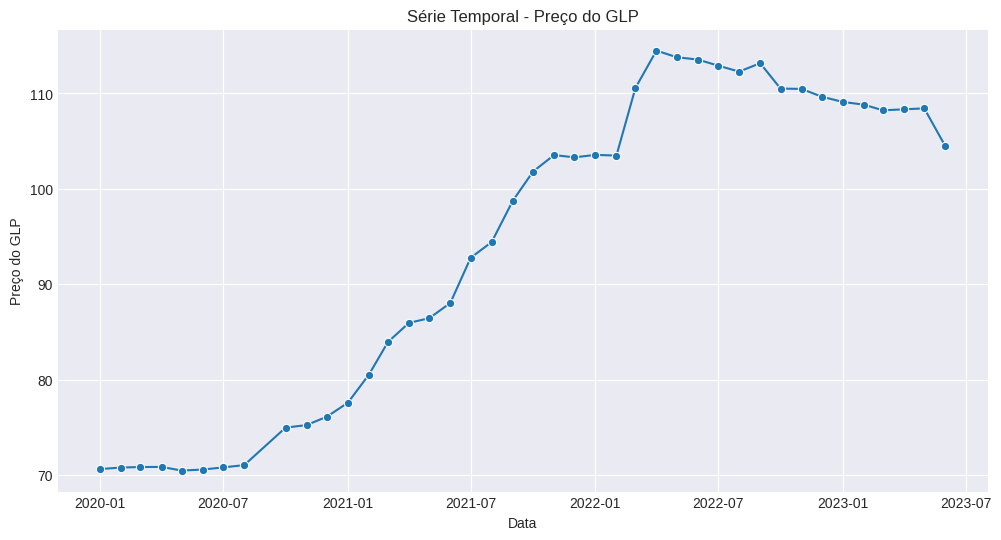

In [90]:
plt.figure(figsize = (12, 6))
sns.lineplot(
    data = anl_serie,
    x = 'Periodo',
    y='Media',
    marker='o',
    linestyle='-')
plt.title('Série Temporal - Preço do GLP')
plt.xlabel('Data')
plt.ylabel('Preço do GLP')
plt.grid(True)

### Matriz de correlação e mapa de calor

Plotou-se agora um mapa de calor da matriz de correlação entre as variáveis presentes na série temporal

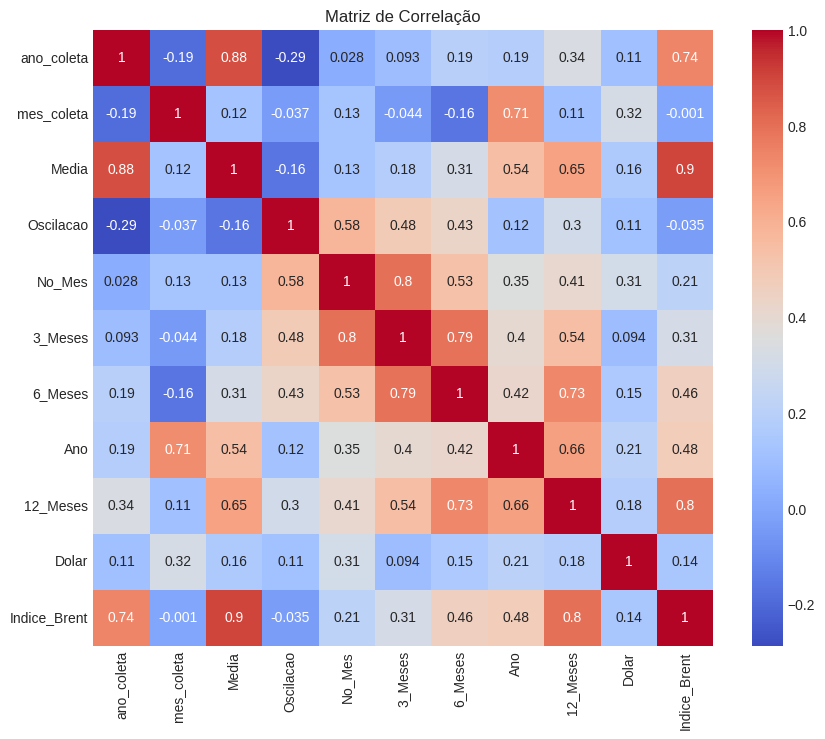

In [98]:
corr = anl_serie.corr()

plt.figure(figsize = (10,8))
sns.heatmap(
    data = corr,
    annot = True,
    cmap = 'coolwarm'
)
plt.title('Matriz de Correlação');

Avaliando-se o mapa de calor acima, para a coluna 'Media', as variáveis que tiveram maior influência foram o Indice_Brent, 12_Meses (inflação acumulada em um ano) e o Dolar. As demais são variáveis temporais e já foram analisadas anteriormente. Portanto, analisou-se cada um deles de forma separada.

### Preço GLP + Índice Brent

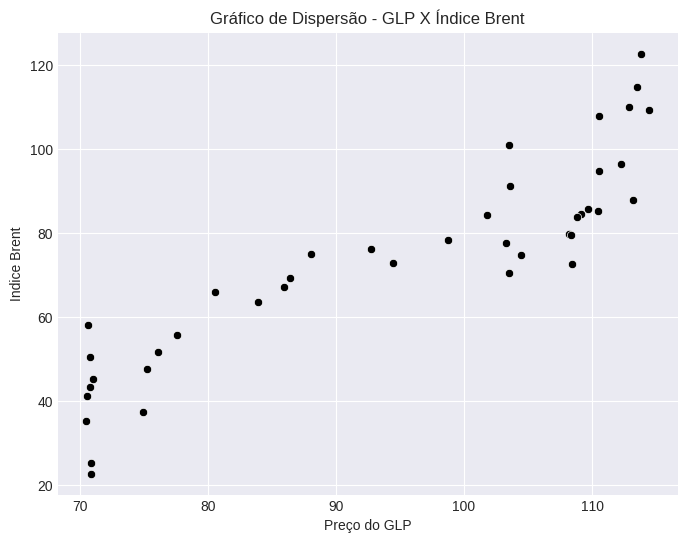

In [114]:
plt.figure(figsize = (8, 6))
sns.scatterplot(data = anl_serie, x='Media', y='Indice_Brent', color='black', marker='o')
plt.title('Gráfico de Dispersão - GLP X Índice Brent')
plt.xlabel('Preço do GLP')
plt.ylabel('Indice Brent')
plt.grid(True)

Observando o gráfico acima, é possível perceber uma forte relação positiva entre as duas variáveis em questão. Plotando-se então um gráfico de dispersão com a linha de regressão linear,

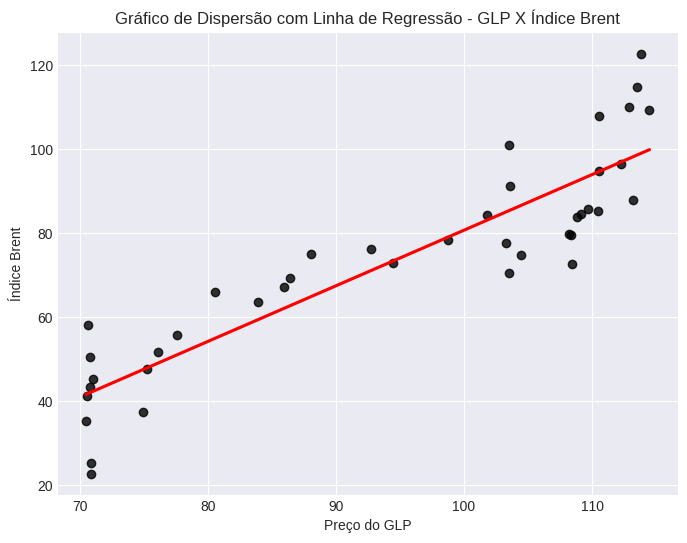

In [115]:
plt.figure(figsize = (8, 6))
sns.regplot(
    data = anl_serie,
    x ='Media',
    y = 'Indice_Brent',
    color = 'black',
    line_kws = {'color': 'red'},
    ci = False
)
plt.title(f'Gráfico de Dispersão com Linha de Regressão - GLP X Índice Brent')
plt.xlabel('Preço do GLP')
plt.ylabel('Índice Brent')
plt.grid(True)

### Preço do GLP + Dólar

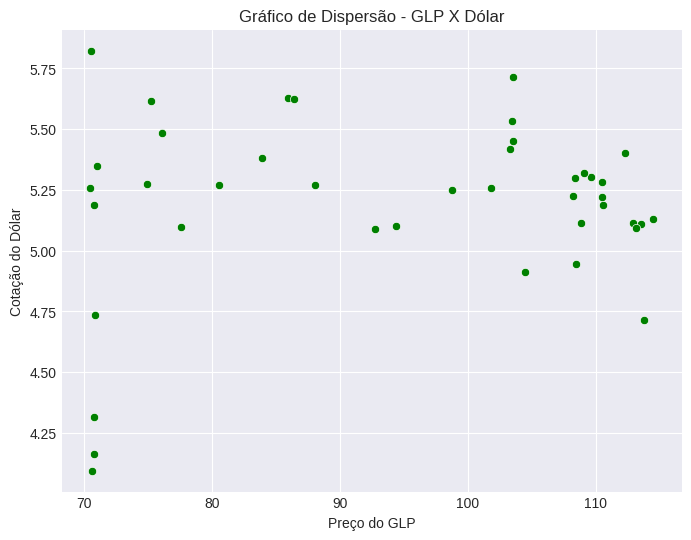

In [116]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data = anl_serie, x = 'Media', y = 'Dolar', color = 'green', marker='o')
plt.title('Gráfico de Dispersão - GLP X Dólar')
plt.xlabel('Preço do GLP')
plt.ylabel('Cotação do Dólar')
plt.grid(True)

Para este caso, percebe-se que a relação entre o preço do GLP e a cotação do dólar, durante o período analisado, é bem fraca. Os pontos estão bem dispersos e quase não é possível estabelecer um padrão de comportamento entre eles.

### Preço do GLP + IPCA

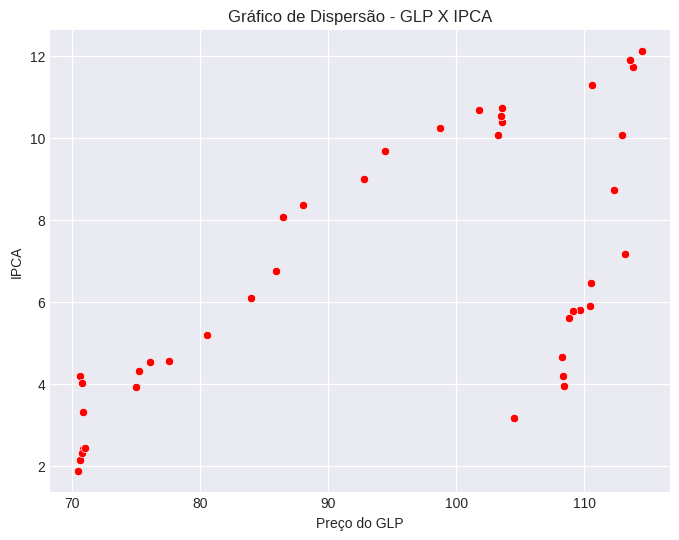

In [117]:
plt.figure(figsize = (8, 6))
sns.scatterplot(data = anl_serie, x = 'Media', y = '12_Meses', color = 'red', marker='o')
plt.title('Gráfico de Dispersão - GLP X IPCA')
plt.xlabel('Preço do GLP')
plt.ylabel('IPCA')
plt.grid(True)

Analisando o gráfico, percebe-se uma relação positiva bem mais forte entre o IPCA e o preço do GLP, se comparado ao Dólar por exemplo. Mas ainda assim, está em um nível de correlação abaixo, se tomarmos como base o Índice Brent.

### Aumento do preço do GLP com o tempo

Por fim, avaliou-se o aumento do preço do gás GLP ao longo do tempo. Para tal, crio-se duas colunas a mais no Data Frame, uma que representa a diferença entre os preços (sempre tomando como referência o preço de janeiro de 2020) e a outra com a data simplificada, exibindo apenas o ano e o mês.

In [111]:
anl_serie['Aumento_Preco'] = anl_serie['Media'] - anl_serie['Media'][0]
anl_serie['Ano_Mes'] = anl_serie['ano_coleta'].astype('str')+ '-' +anl_serie['mes_coleta'].astype('str')
anl_serie.head()

,Periodo,ano_coleta,mes_coleta,Media,Oscilacao,No_Mes,3_Meses,6_Meses,Ano,12_Meses,Dolar,Indice_Brent,Aumento_Preco,Ano_Mes
0,2020-01-01,2020,1,70.626936,NaN,0.21,1.88,2.05,0.21,4.19,4.0949,58.16,0.000000,2020-1
1,2020-02-01,2020,2,70.789624,0.230347,0.25,1.62,2.20,0.46,4.01,4.1622,50.52,0.162687,2020-2
2,2020-03-01,2020,3,70.843771,0.076490,0.07,0.53,2.31,0.53,3.30,4.3163,22.74,0.216834,2020-3
3,2020-04-01,2020,4,70.855663,0.016786,-0.31,0.01,1.89,0.22,2.40,4.7362,25.27,0.228726,2020-4
4,2020-05-01,2020,5,70.471334,-0.542410,-0.38,-0.62,0.99,-0.16,1.88,5.2579,35.33,-0.155602,2020-5


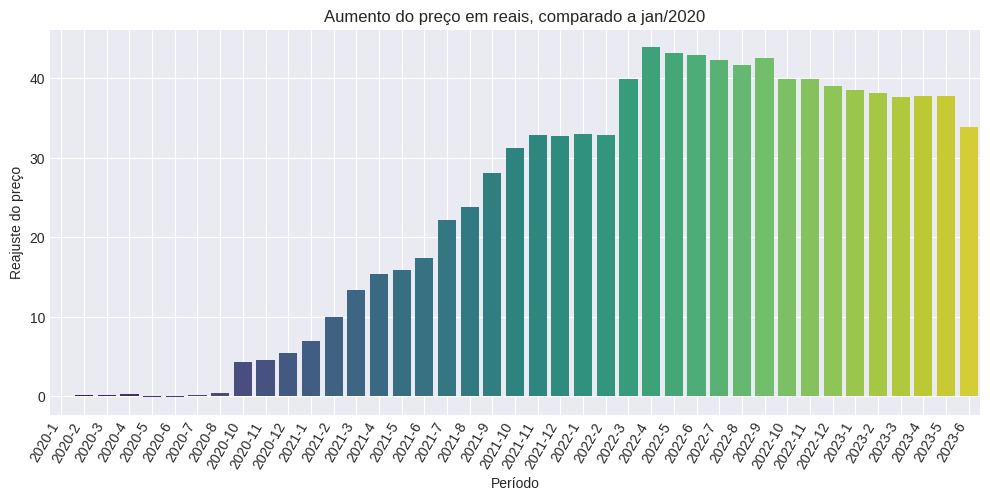

In [118]:
plt.figure(figsize = (12, 5))
sns.barplot(data = anl_serie, x = 'Ano_Mes', y = 'Aumento_Preco', palette='viridis')
plt.title('Aumento do preço em reais, comparado a jan/2020')
plt.xlabel('Período')
plt.ylabel('Reajuste do preço')
plt.xticks(rotation=60, ha ='right')
plt.grid(True)

## Conclusão

Após as análises feitas ao longo do projeto, foi possível concluir que o preço do GLP variou muito ao longo destes últimos 3 anos. Esta variação se deve, entre outros aspectos, principalmente a Pandemia de 2020, o que fez com o preço do gás de cozinha disparasse, saindo de duma casa de 70,00 para valores próximos a 120,00 no ano de 2022. Conforme a Pandemia foi perdendo, observa-se uma tendência a diminuição, de forma gradativa e lenta, atingindo os 100,00 no mês de junho deste ano de 2023.

Outro aspecto importante avaliado foram as influências de alguns fatores chave no preço GLP, principalmente o Índice Brent e a inflação nacional. Além disso, concluí-se também que o valor do dólar não interferiu de forma tão desciva assim no valor do gás de cozinha. Lembrando que esta é uma análise de janeiro de 2020 até junho de 2023, estas variáveis podem sim ter influenciado em maior ou menor escala em outros períodos históricos.

Avaliando estes resultados na ótica de uma empresa que trabalha com distruibuição de gás GLP, no período de 2020 até a metade do ano de 2022, seria muito importante o estoque de gás, pois o aumento no valor era constante. Mas, após este período, existe uma queda de preço gradativa, indicando que é mais vantajoso comprar sob demandar do que manter altos estoques.